## Data Handling

This notebook intends to do four main tasks for the current project that set the scene for training our cycle-GAN model: <p>
1.   Data collection
2.   Data cleaning
3.   Data analysis
4.   Data indexing

### Notebook setup

In [16]:
# Standard built-in modules
import os
import pickle
import random
import warnings

# Third-party modules
import gdown
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import scipy
from skimage.io import imread as sk_imread
from skimage.transform import resize as sk_resize
from skimage.util import invert as sk_invert

# Local modules
import scripts.utils.python_utils as pu

# Configurations
warnings.filterwarnings("ignore") 
root_path = os.path.dirname(os.path.abspath(''))
sep = os.path.sep

### Data collection
The data we need consists of two sets of pelvix Xrays from primary THA patients: 1- pre-op & 2- post-op.
We can collect this data using our THA imaging registry.

In [17]:
imaging_registry_path = '/research/datasets/Mayo_THA/THA_XR_Registry_PrimaryANDRevison_1998to2020.csv'
registry_df = pd.read_csv(imaging_registry_path)
registry_df.head()

,PatientID,PatientName,PatientSex,StudyDate,AccessionNumber,StudyDescription,SeriesDescription,Manufacturer,Modality,SOPClassUID,SOPInstanceUID,PhotometricInterpretation,Array_Shape,DICOM_Name,DICOM_Path,View,Visible_Joint,Visible_Prosthesis,Surgery_Date,Joint_Coordinates
0,2922281,"AADAHL, CYNTHIA",F,20130920,IIMS5401199,Pelvis,Hip LAT,Agfa,CR,1.2.840.10008.5.1.4.1.1.1,1.3.51.0.7.11732147470.49256.31811.37455.49650...,MONOCHROME2,"(2570, 2040)",1.3.51.0.7.11732147470.49256.31811.37455.49650...,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,Oblique,RIGHT,RIGHT,False,NaN
1,2922281,"AADAHL, CYNTHIA",F,20120328,429892903-1,R DX HIP 2+ VIEWS,Hip LAT,Agfa,CR,1.2.840.10008.5.1.4.1.1.1,1.3.51.0.7.13443381020.29495.11589.33919.23852...,MONOCHROME2,"(2570, 2040)",1.3.51.0.7.13443381020.29495.11589.33919.23852...,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,Oblique,RIGHT,NaN,False,NaN
2,2922281,"AADAHL, CYNTHIA",F,20130920,IIMS5401199,Pelvis,Hip LAT,Agfa,CR,1.2.840.10008.5.1.4.1.1.1,1.3.51.0.7.12825728855.6289.55882.41371.56603....,MONOCHROME2,"(2570, 2040)",1.3.51.0.7.12825728855.6289.55882.41371.56603....,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,Oblique,RIGHT,RIGHT,False,NaN
3,2922281,"AADAHL, CYNTHIA",F,20130920,IIMS5401199,Pelvis,Pelvis AP,Agfa,CR,1.2.840.10008.5.1.4.1.1.1,1.3.51.0.7.384495980.52802.14661.42986.55895.2...,MONOCHROME2,"(2048, 2494)",1.3.51.0.7.384495980.52802.14661.42986.55895.2...,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,AP,BOTH,RIGHT,False,"[{'class': 3.0, 'label': 'Pre-left', 'confiden..."
4,2922281,"AADAHL, CYNTHIA",F,20130715,15536481-1,R DX HIP 2+ VIEWS,Lateral,Philips Medical Systems,CR,1.2.840.10008.5.1.4.1.1.1,1.3.46.670589.30.1.3.1.203050744550132.1373900...,MONOCHROME2,"(1760, 2140)",1.3.46.670589.30.1.3.1.203050744550132.1373900...,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,Lateral,RIGHT,RIGHT,True,NaN


### Data cleaning
To clean the data we need to 1) limit our dataframe to AP Xrays which are not from the surgery date, 2) have one row per each visible joint on the radiograph, and 3) exclude the Xrays for revision surgeries.

In [38]:
# Excluding the surgery_date Xrays.
temp_df = registry_df[registry_df['Surgery_Date']==False]

# Only including the AP and PA Xrays.
temp_df = temp_df[temp_df['View']=='AP']

# Only including the patients with determined gender.
temp_df = temp_df[temp_df['PatientSex'].isin(['F', 'M'])]

In [39]:
# Creating a new dataframe with one visible joint per row.
target_df_dict = {'PatientID':[], 'PatientSex':[], 'StudyDate':[], 
                  'SIDE':[], 'STATE':[], 'PhotometricInterpretation':[], 
                  'X_min':[], 'Y_min': [], 'Width': [], 'Height':[], 
                  'Confidence':[], 'DICOM_Path':[]}
for i, (_, row) in enumerate(tqdm(temp_df.iterrows(), total=temp_df.shape[0])):
    coordinate_dict = eval(row['Joint_Coordinates'])
    for joint in coordinate_dict:
        target_df_dict['PatientID'].append(int(row['PatientID']))
        target_df_dict['PatientSex'].append('FEMALE') if row['PatientSex'] == 'F' else target_df_dict['PatientSex'].append('MALE')
        target_df_dict['StudyDate'].append(int(row['StudyDate']))
        target_df_dict['PhotometricInterpretation'].append(row['PhotometricInterpretation'])
        target_df_dict['DICOM_Path'].append(row['DICOM_Path'])
        target_df_dict['SIDE'].append('LEFT') if 'left' in joint['label'].lower() else target_df_dict['SIDE'].append('RIGHT')
        target_df_dict['STATE'].append('PRE') if 'pre' in joint['label'].lower() else target_df_dict['STATE'].append('POST')
        target_df_dict['X_min'].append(int(joint['x_min']))
        target_df_dict['Y_min'].append(int(joint['y_min']))
        target_df_dict['Width'].append(int(joint['width']))
        target_df_dict['Height'].append(int(joint['height']))
        target_df_dict['Confidence'].append(float(joint['confidence']))
        
target_df = pd.DataFrame(target_df_dict)
print(f'The number of identified joints: {len(target_df)}')
target_df.head()

  0%|          | 0/303495 [00:00<?, ?it/s]

The number of identified joints: 447327


,PatientID,PatientSex,StudyDate,SIDE,STATE,PhotometricInterpretation,X_min,Y_min,Width,Height,Confidence,DICOM_Path
0,2922281,FEMALE,20130920,LEFT,PRE,MONOCHROME2,1180,935,1091,679,0.964110,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
1,2922281,FEMALE,20130920,RIGHT,POST,MONOCHROME2,77,723,1102,912,0.968384,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
2,2922281,FEMALE,20120328,RIGHT,PRE,MONOCHROME2,66,801,1113,701,0.959190,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
3,2922281,FEMALE,20120328,LEFT,PRE,MONOCHROME2,1180,745,1102,690,0.964905,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
4,2922281,FEMALE,20130920,LEFT,PRE,MONOCHROME2,1180,935,1091,679,0.964110,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...


Excluding the Xrays for revision surgeris by cross-cheking the temp_df with the clinial registry.

In [20]:
# Loading the clinical registry.
clincal_df_path = '/research/datasets/Mayo_THA/THA_Clinical_Registry_PrimaryANDRevision_1969to2020.xlsx'
clinical_df = pd.read_excel(clincal_df_path)
clinical_df.head()

,CLINIC,LAST_NAME,GENDER,SIDE,JOINT,SURGERY_DATE,SURGERY_TYPE,BIRTH_DATE,DEATH_DATE,AGE_AT_SURGERY,...,SCOPE_INDICATOR6,PRIOR_SURGERY_CODE7,PRIOR_SURGERY_DESCRIPTION7,SCOPE_INDICATOR7,PRIOR_SURGERY_CODE8,PRIOR_SURGERY_DESCRIPTION8,SCOPE_INDICATOR8,PRIOR_SURGERY_CODE9,PRIOR_SURGERY_DESCRIPTION9,SCOPE_INDICATOR9
0,4690,Nash,MALE,RIGHT,HIP,1988-04-21,PRIMARY,1905-06-11,2000-09-01,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6012,Hale,MALE,LEFT,HIP,1992-12-09,PRIMARY,1907-09-10,2002-02-25,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6508,Vegger,FEMALE,RIGHT,HIP,1981-12-01,PRIMARY,1886-07-23,1986-01-18,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6881,Cowan,MALE,LEFT,HIP,1971-04-19,PRIMARY,1885-07-13,1978-09-25,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7018,Coon,FEMALE,LEFT,HIP,1971-09-26,PRIMARY,1886-03-04,1972-01-09,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Creating a dictionary that stores a sorted list of surgery dates for each patient.
surgery_dates_dict = dict()
for _, row in clinical_df.iterrows():
    try:
        key = (int(row['CLINIC']), row['SIDE'])
        dates = surgery_dates_dict.get(key, [])
        dates.append(int(''.join(str(row['SURGERY_DATE'])[:10].split('-'))))
        dates.sort()
        surgery_dates_dict[key] = dates
    except ValueError:
        print(str(row['SURGERY_DATE'])) # One record had no surgery date.
with open(f'{root_path}{sep}data{sep}surgery_dates_for_pids.dat', 'wb') as f:
    pickle.dump(surgery_dates_dict, f)

NaT


In [40]:
# Excluding the Xrays which their studydate is in surgerydates or later than the second surgery date.
indices_to_drop = list()
for index, row in tqdm(target_df.iterrows(), total=target_df.shape[0]):
    studydate = row['StudyDate']
    key = (int(row['PatientID']), row['SIDE'])
    if key in surgery_dates_dict:
        surgery_dates = surgery_dates_dict[key]
        if len(surgery_dates) ==1 or studydate in surgery_dates:
            continue
        elif studydate > surgery_dates[1]:
           indices_to_drop.append(index)

  0%|          | 0/447327 [00:00<?, ?it/s]

In [41]:
print(f'The number of Xrays before dropping: {len(target_df)}')
print(f'The number of Xrays to drop: {len(indices_to_drop)}')
target_df = target_df.drop(indices_to_drop)
print(f'The number of Xrays after dropping: {len(target_df)}')

The number of Xrays before dropping: 447327
The number of Xrays to drop: 34193
The number of Xrays after dropping: 413134


In [42]:
target_df.head()

,PatientID,PatientSex,StudyDate,SIDE,STATE,PhotometricInterpretation,X_min,Y_min,Width,Height,Confidence,DICOM_Path
0,2922281,FEMALE,20130920,LEFT,PRE,MONOCHROME2,1180,935,1091,679,0.964110,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
1,2922281,FEMALE,20130920,RIGHT,POST,MONOCHROME2,77,723,1102,912,0.968384,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
2,2922281,FEMALE,20120328,RIGHT,PRE,MONOCHROME2,66,801,1113,701,0.959190,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
3,2922281,FEMALE,20120328,LEFT,PRE,MONOCHROME2,1180,745,1102,690,0.964905,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...
4,2922281,FEMALE,20130920,LEFT,PRE,MONOCHROME2,1180,935,1091,679,0.964110,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...


### Data analysis
Here we print some basic stats of our dataframe and also visualize random batches of pre-op and post-op Xrays.

In [43]:
# Printing dataframe stats.
print('The basic stats for the dataframe: ')
print('-'*50)
print(f'Number of available records: {len(target_df)}')
print(f'Number of unique Xrays: {len(target_df["DICOM_Path"].unique())}')
print(f'Number of unique patients: {len(target_df["PatientID"].unique())}')
for key in ['PatientSex', 'SIDE', 'STATE', 'PhotometricInterpretation']:
    print('-'*50)
    for unique_value in target_df[key].unique():
        print(f'Number of records with {key} = {unique_value}: {len(target_df[target_df[key]==unique_value])}')

The basic stats for the dataframe: 
--------------------------------------------------
Number of available records: 413134
Number of unique Xrays: 286094
Number of unique patients: 19644
--------------------------------------------------
Number of records with PatientSex = FEMALE: 215815
Number of records with PatientSex = MALE: 197319
--------------------------------------------------
Number of records with SIDE = LEFT: 203810
Number of records with SIDE = RIGHT: 209324
--------------------------------------------------
Number of records with STATE = PRE: 162011
Number of records with STATE = POST: 251123
--------------------------------------------------
Number of records with PhotometricInterpretation = MONOCHROME2: 307661
Number of records with PhotometricInterpretation = MONOCHROME1: 105473


In [26]:
# Defining a function to load images from disk.

def load_img(row: pd.core.series.Series, crop: bool = False, resize: int = -1,
             dilation: int = 0) -> np.ndarray:
    """A function to laod an image from a row of the dataframe.

    Args:
        row (pd.core.series.Series): A row of the target_df.
        crop (bool, optional): whether to crop the images based on the joint coordinates or not. 
            Defaults to False.
        dilation (int, optional): the amount of dilation to apply to the image. Defaults to 0.
        resize: (int, optional): the size to resize the image to. 
            Defaults to -1, which means no resizing.

    Returns:
        img (np.ndarray): the processed image to be visualized.
    """
    # Loading the image.
    img = pydicom.read_file(row['DICOM_Path']).pixel_array
    if img.ndim==3:
        img = np.mean(img, axis=2)
    
    # Inverting the image if necessary.
    if row['PhotometricInterpretation'] == 'MONOCHROME1':
        img = sk_invert(img)
    
    # Cropping the image if necessary.
    if crop:
        if not isinstance(dilation, int) or dilation < 0:
            raise ValueError('dilation value must be a positive integer.')
        ymin = max(row['Y_min'] - dilation, 0)
        ymax = min(row['Y_min'] + row['Height'] + dilation, img.shape[0])
        xmin = max(row['X_min'] - dilation, 0)
        xmax = min(row['X_min'] + row['Width'] + dilation, img.shape[1])
        img = img[ymin:ymax, xmin:xmax]
    
    # Standardizing the image.
    percentile_low = np.percentile(img, 2.5)
    percentile_high = np.percentile(img, 97.5)
    img = np.clip(img, percentile_low, percentile_high)
    img = np.array(img, dtype='float32')
    img -= img.mean()
    img /= (img.std() + 1e-10)
    img -= np.min(img)
    
    # Padding the image to make it square.
    height, width = img.shape
    if height < width: 
        padded_img = np.zeros((width, width))
        delta = (width - height) // 2
        padded_img[delta:height+delta, :] = img
        img = padded_img
    elif height > width:
        padded_img = np.zeros((height, height))
        delta = (height - width) // 2
        padded_img[:, delta:width+delta] = img
        img = padded_img
        
    # Resizing the image to the desired size.
    if resize != -1:
        if not isinstance(resize, int) or resize < 10:
            raise ValueError('The resize parameter must be an integer greater than 10.')
        img = sk_resize(img, (resize, resize), anti_aliasing=False)
        
    return img

Visualizing a random batch of pre-op Xrays.


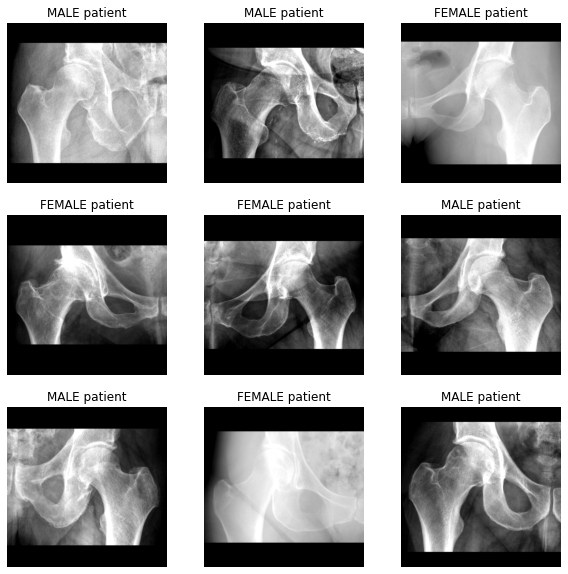

In [27]:
# Visualizing a random batch from the pre-op Xrays.

pre_df = target_df[target_df['STATE']=='PRE']
print('Visualizing a random batch of pre-op Xrays.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
random_indices = np.random.choice(len(pre_df), 9, replace=False)
for i in range(9):
    ax = axes[i//3, i%3]
    row = pre_df.iloc[random_indices[i]]
    img = load_img(row, resize=1024, crop=True, dilation=50)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{row["PatientSex"]} patient')

Visualizing a random batch of post-op Xrays.


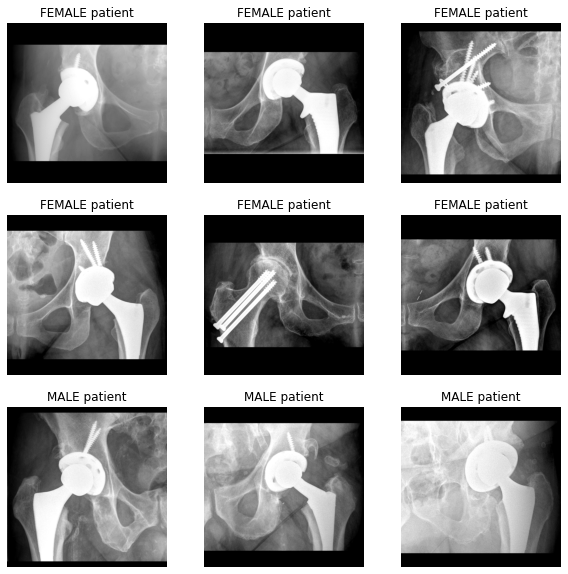

In [28]:
# Visualizing a random batch from the post-op Xrays.

post_df = target_df[target_df['STATE']=='POST']
print('Visualizing a random batch of post-op Xrays.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(9):
    ax = axes[i//3, i%3]
    row = post_df.iloc[random_indices[i]]
    img = load_img(row, resize=1024, crop=True, dilation=50)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{row["PatientSex"]} patient')

## Data indexing
In this final section, we will first seprate a test set consisting of 0.1 of available records, and then split the remaining records to five different folds for training and validaiton. We check that no significant difference exist between the test set and the training/validation set in PatientSex and State using Pearson's Chi-square test. Balancing based on the hip side is not necessary as we will horizontally flip the images during the training.

In [70]:
# Separating a representative test set.
target_df['Y'] = target_df['PatientSex'] + target_df['STATE']
count_try = 1
while count_try < 10:
    print(f'Trying to split the data. Try: {count_try}')
    target_df = pu.split_data(target_df, n_splits=10, y_column='Y', 
                            group_column='PatientID', fold_column='Fold')
    
    # We assign -1 as the fold number for records belonging to the test set.
    target_df['Fold'] = np.where(target_df['Fold']==0, -1, 0)
    set1 = list(target_df[target_df['Fold']==-1]['Y'].value_counts().values)
    set2 = list(target_df[target_df['Fold']==0]['Y'].value_counts().values)
    print(set1, set2)
    stat, p, dof, expected = scipy.stats.chi2_contingency([set1, set2])
    if p > 0.05:
        print('A successful split was found!')
        print(f'{len(target_df[target_df["Fold"]==-1])} records went to the test set.')
        break
    else:
        count_try += 1
        if count_try == 10:
            print('No successful split was found after 10 tries!')
            del target_df['Fold']
            break
    print('-'*50)

target_df.head()

Trying to split the data. Try: 1
Using StratifiedGroupKFold split...
[13269, 11844, 8313, 7888] [119420, 106590, 74813, 70997]
A successful split was found!
41314 records went to the test set.


,PatientID,PatientSex,StudyDate,SIDE,STATE,PhotometricInterpretation,X_min,Y_min,Width,Height,Confidence,DICOM_Path,Y,Fold
0,2922281,FEMALE,20130920,LEFT,PRE,MONOCHROME2,1180,935,1091,679,0.964110,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,FEMALEPRE,0
1,2922281,FEMALE,20130920,RIGHT,POST,MONOCHROME2,77,723,1102,912,0.968384,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,FEMALEPOST,0
2,2922281,FEMALE,20120328,RIGHT,PRE,MONOCHROME2,66,801,1113,701,0.959190,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,FEMALEPRE,0
3,2922281,FEMALE,20120328,LEFT,PRE,MONOCHROME2,1180,745,1102,690,0.964905,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,FEMALEPRE,0
4,2922281,FEMALE,20130920,LEFT,PRE,MONOCHROME2,1180,935,1091,679,0.964110,/research/datasets/Mayo_THA/Mayo_THA_Dataset_P...,FEMALEPRE,0


In [ ]:
# Splitting the non-test records into training and validation sets.
test_df = target_df[target_df['Fold']==-1].copy()
non_test_df = target_df[target_df['Fold']!=-1].copy()

count_try = 1
while count_try < 10:
    print(f'Trying to split the data. Try: {count_try}')
    non_test_df = pu.split_data(non_test_df, n_splits=10, y_column='Y', 
                            group_column='PatientID', fold_column='Fold')
    set_dict = dict()
    for i in range(10):
        set_dict[i] = list(non_test_df[non_test_df['Fold']==i]['Y'].value_counts().values)
    checked_pairs = list()
    condition = False
    for i in range(10):
        for j in range(10):
            if i==j or (i, j) in checked_pairs or (j, i) in checked_pairs: 
                continue
            _, p, _, _ = scipy.stats.chi2_contingency([set_dict[i], set_dict[j]])
            if p<0.05:
                condition = True
                break
            checked_pairs.append((i, j))
            checked_pairs.append((j, i))
        if condition:
            break
    if condition:
        count_try += 1
        if count_try == 10:
            print('No successful split was found after 10 tries!')
            del non_test_df['Fold']
            break
    else:
        print('A successful split was found!')
        break
    print('-'*50)

non_test_df.head()